# Identifying Entities in Healthcare Data

#**Problem Statement**

Now, let’s consider a hypothetical example of a health tech company called ‘BeHealthy’. Suppose ‘BeHealthy’ aims to connect the medical communities with millions of patients across the country. 

 

‘BeHealthy’ has a web platform that allows doctors to list their services and manage patient interactions and provides services for patients such as booking interactions with doctors and ordering medicines online. Here, doctors can easily organise appointments, track past medical records and provide e-prescriptions.

 

So, companies like ‘BeHealthy’ are providing medical services, prescriptions and online consultations and generating huge data day by day.

 

Let’s take a look at the following snippet of medical data that may be generated when a doctor is writing notes to his/her patient or as a review of a therapy that he or she has done.

 

“The patient was a 62-year-old man with squamous cell lung cancer, which was first successfully treated by a combination of radiation therapy and chemotherapy.”

 

As you can see in this text, a person with a non-medical background cannot understand the various medical terms. We have taken a simple sentence from a medical data set to understand the problem and where you can understand the terms ‘cancer’ and ‘chemotherapy’. 

 

Suppose you have been given such a data set in which a lot of text is written related to the medical domain. As you can see in the dataset, there are a lot of diseases that can be mentioned in the entire dataset and their related treatments are also mentioned implicitly in the text, which you saw in the aforementioned example that the disease mentioned is cancer and its treatment can be identified as chemotherapy using the sentence.

 

But, note that it is not explicitly mentioned in the dataset about the diseases and their treatment, but somehow, you can build an algorithm to map the diseases and their respective treatment.

 

Suppose you have been asked to determine the disease name and its probable treatment from the dataset and list it out in the form of a table or a dictionary like this.

 



 

After discussing the problem given above, you need to build a custom NER to get the list of diseases and their treatment from the dataset.

 

Let’s first download the dataset given below.

In this assignment, we need to perform the following broad steps:

we need to process and modify the data into sentence format. This step has to be done for the 'train_sent' and ‘train_label’ datasets and for test datasets as well.
After that, we need to define the features to build the CRF model.
Then, we need to apply these features in each sentence of the train and the test dataset to get the feature values.
Once the features are computed, we need to define the target variable and then build the CRF model.
Then, we need to perform the evaluation using a test data set.
After that, we need to create a dictionary in which diseases are keys and treatments are values.

##Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite
!pip install sklearn-crfsuite==0.3.6

import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

import pandas as pd
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from collections import Counter


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1897 sha256=46a588db067b9ea489cdd3e9b7e27927823a6634771cf8fbb4ba1c5f0e6e5dc2
  Stored in directory: /root/.cache/pip/wheels/da/5c/29/bf862cc934550145485b0e0502cb8deadffb387f6a096e4b5f
Successfully built pycrf
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


##Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

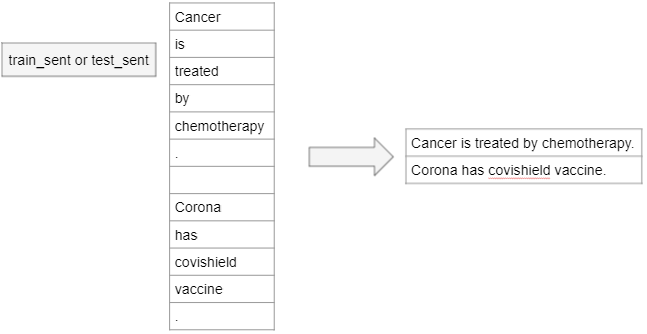

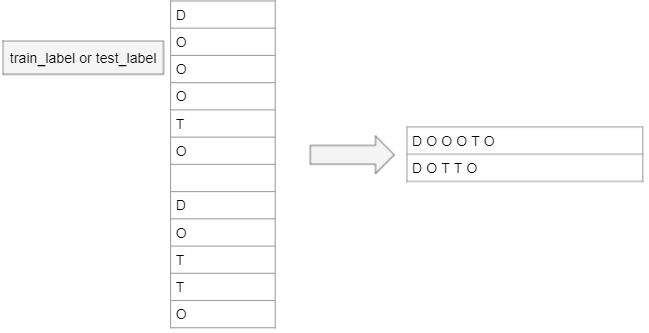

In [2]:
# Create a function to convert the input file words to sentences and store it in a list
def create_sentence(file_name):
  with open(file_name, 'r') as file:
      content = file.readlines()

  sent = ''
  sentArr = []
  # Strip newlines from each line and remove any empty lines
  #content = [line.strip() for line in content if line.strip()]
  for line in content:
    if not line.strip():
        sentArr.append(sent)
        sent = ''
    else:     
        sent = sent + ' ' + line.replace('\n','')
        sent = sent.strip()
  return sentArr


In [3]:
# Converting the train and test (including the label files for each) words into sentence by calling the create_sentence function
train_sent_processed = create_sentence('train_sent')
train_label_processed = create_sentence('train_label')
test_sent_processed = create_sentence('test_sent')
test_label_processed = create_sentence('test_label')

In [4]:
# Samples
print(train_sent_processed[10])
print(train_sent_processed[11])
print(train_sent_processed[12])

print(test_sent_processed[14])
print(test_sent_processed[15])
print(test_sent_processed[16])

A 2- , 3- , and 4-day mean temperature prior to the test date was compared to AFI using a Spearman-rank Correlation
This relationship should be taken into account when interpreting the AFI as a measure of fetal well-being
The study population included 84 women with gestational diabetes , ascertained by universal screening of all women attending the antenatal clinic of the Hadassah Medical Center , over a 2-year period
These were matched for maternal age , parity , and race to twin gestations ( N = 53 ) from the same population
The rate of severe preeclampsia was increased significantly in the triplet group 12 of 53 ( 22.6 % ) as compared with the twin group 3 of 53 ( 5.7 % ) ( OR = 4.9 , 95 % CI 1.2-23.5 , p = 0.02 )
We conducted a survey and audit of thermal equipment use in very low-birth-weight infants in five Ohio neonatal intensive care units ( NICUs ) to document regional practice


In [5]:
# Create a full_corpus to get the complete word frequency and store it in a set word_freq_set
# It will be later used in feature definition
processed_corpus = train_sent_processed + test_sent_processed

full_corpus = []

for sent in processed_corpus:
    wds = sent.split()
    postags = nltk.pos_tag(wds)

    for wd, pos in postags:
        full_corpus.append(wd)

freq_dist = Counter(full_corpus)

word_freq_set = {}
for token, freq in freq_dist.items():
    word_freq_set[token] = freq
print(word_freq_set)

{'All': 12, 'live': 3, 'births': 2, '>': 101, 'or': 269, '=': 72, '23': 4, 'weeks': 37, 'at': 157, 'the': 2307, 'University': 6, 'of': 2982, 'Vermont': 1, 'in': 1666, '1995': 14, '(': 921, 'n': 22, '2395': 2, ')': 920, 'were': 278, 'retrospectively': 3, 'analyzed': 16, 'for': 856, 'delivery': 21, 'route': 2, ',': 2030, 'indication': 5, 'cesarean': 6, 'gestational': 20, 'age': 52, 'parity': 4, 'and': 1882, 'practice': 31, 'group': 89, 'to': 905, 'reflect': 3, 'risk': 66, 'status': 17, 'The': 415, 'total': 25, 'rate': 67, 'was': 371, '14.4': 1, '%': 247, '344': 2, 'primary': 63, '11.4': 1, '244': 1, '2144': 1, 'Abnormal': 1, 'presentation': 7, 'most': 37, 'common': 32, '25.6': 1, '88': 1, '``': 52, 'corrected': 4, "''": 50, 'maternal-fetal': 1, 'medicine': 35, 'transported': 2, 'patients': 492, 'excluded': 3, '12.4': 1, '273': 1, '2194': 1, '9.6': 3, '190': 2, '1975': 1, 'Arrest': 1, 'dilation': 4, 'both': 59, 'subgroups': 4, '23.4': 1, '24.6': 1, 'respectively': 25, 'Cesarean': 3, 'rate

In [6]:
# Sample
word_freq_set['Cesarean']

3

### Count the number of sentences in the processed train and test dataset 

In [7]:
print('the number of sentences in the processed train dataset: ',len(train_sent_processed))
print('the number of sentences in the processed test dataset: ',len(test_sent_processed))

the number of sentences in the processed train dataset:  2599
the number of sentences in the processed test dataset:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [8]:
print('the number of lines of labels in the processed train dataset: ', len(train_label_processed))
print('the number of lines of labels in the processed test dataset: ', len(test_label_processed))

the number of lines of labels in the processed train dataset:  2599
the number of lines of labels in the processed test dataset:  1056


##Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [9]:
# Loop through each sentence and extract its POS tags
word_NN_PROPN = []
pos_NN_PROPN = []
freq_NN_PROPN = []
full_corpus = []
for sentence in train_sent_processed:
    # Tokenize the sentence into words
    #words = nltk.word_tokenize(sentence)
    words = sentence.split()
    

    # Tag the words with their POS tags
    pos_tags = nltk.pos_tag(words)

    # Print the POS tags for each word in the sentence
    for word, pos in pos_tags:
      full_corpus.append(word)
      if pos == 'NN' or pos == 'NNP': 
        word_NN_PROPN.append(word)
        pos_NN_PROPN.append(pos)

#for token, freq in freq_dist.items():
#print(token, freq)


In [10]:
# Count the frequency of each token only Noun and Proper Nouns
freq_dist = Counter(word_NN_PROPN)

for token, freq in freq_dist.items():
    print(token, freq)

University 6
Vermont 1
= 33
delivery 18
route 2
indication 3
cesarean 1
age 33
parity 1
practice 22
group 59
risk 46
status 14
rate 46
% 161
presentation 6
medicine 27
Arrest 1
dilation 1
care 47
community 7
patient 49
trimester 3
fluid 6
index 11
AFI 5
temperature 4
decrease 3
June 2
August 4
period 22
heat 2
gestation 4
testing 9
ambient 1
area 8
mean 4
test 14
date 2
Correlation 3
relationship 9
account 5
measure 3
well-being 1
study 103
population 21
screening 9
clinic 3
Hadassah 1
Medical 4
Center 3
treatment 194
week 3
protocol 5
control 25
mode 3
Apgar 1
aim 7
contribution 3
diagnosis 40
Down 4
syndrome 43
Edward 2
Patau 2
pyelectasis 1
atresia 1
hydrocephalus 2
growth 27
retardation 1
bradycardia 3
hydronephrosis 1
triplet 3
New 15
York 4
Hospital-Cornell 1
preeclampsia 13
Student 1
t-test 1
Fisher 4
Chi-square 2
analysis 42
pre-eclampsia 1
information 13
order 6
survey 6
variety 5
NICUs 3
radiant 2
audit 4
use 53
plastic 3
humidity 1
variability 4
equipment 3
management 34
rep

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [11]:
for token, freq in freq_dist.most_common(25):
    print(token, freq)

treatment 194
% 161
cancer 135
therapy 120
study 103
disease 100
lung 84
cell 73
> 60
chemotherapy 60
group 59
TO_SEE 55
gene 54
use 53
patient 49
surgery 49
care 47
risk 46
rate 46
survival 46
activity 46
combination 44
health 44
syndrome 43
analysis 42


## Defining features for CRF
We have defined the following features for CRF model building:


*   f1 = input word is in lower case;
*   f2 = last 3 characers of word;
*   f3 = last 2 characers of word;
*   f4 = True; if the word is in uppercase, False otherwise;
*   f5 = True; if word is a number; otherwise, False
*   f6 =  True; if the word starts with a capital letter; otherwise, False
*   f7 =  True; if the word is Noun or Proper Noun; otherwise, False
*   f8 =  POS TAG of the word
*   f9 =  frequency of the word in the full corpus

*   f10 = previous word is in lower case;
*   f11 = True; if the previous word is in uppercase, False otherwise;
*   f12 = True; if previous word is a number; otherwise, False
*   f13 = True; if the word starts with a capital letter; otherwise, False
*   f14 = True; if the word is Noun or Proper Noun; otherwise, False
*   f15 = POS TAG of the word


















In [12]:
# Let's define the features to get the feature value for one word.
# Write a code to get features for a sentence.
def getFeaturesForOneWord(sentence, pos):
  word = sentence[pos]
  features = [
    'word.lower=' + word.lower(), # serves as word id
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # is the word a number
    'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
    'word.isNNOrPROPN=%s' % (True if nltk.pos_tag([word])[0][1] in ['NN','NNS','PROPN','NNP','NNPS','PRP','PDT'] else False),
    'word.postag=' + nltk.pos_tag([word])[0][1],
    'word.freq=%s' % (True if word_freq_set[word] < 10 else False)
  ]

  if(pos > 0):
    prev_word = sentence[pos-1]
    features.extend([
    'prev_word.lower=' + prev_word.lower(), 
    'prev_word.isupper=%s' % prev_word.isupper(),
    'prev_word.isdigit=%s' % prev_word.isdigit(),
    'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    'prev_word.isNNorPROPN=%s' % (True if nltk.pos_tag([prev_word])[0][1] in ['NN','NNS','PROPN','NNP','NNPS','PRP','PDT'] else False),
    'prev_word.isadj=%s' % (True if nltk.pos_tag([prev_word])[0][1] == 'JJ' else False),
    'prev_word.postag=' + nltk.pos_tag([word])[0][1]
  ])
  else:
    features.append('BEG') # feature to track begin of sentence 

  if(pos == len(sentence)-1):
    features.append('END') # feature to track end of sentence

  return features

## Getting the features

### Write a code/function to get the features for a sentence

In [13]:
  def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [14]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [15]:
# Apply function 'getFeaturesForOneSentence' to get features on a single sentence which is at index value 5 in train_sentences
example_sentence = train_sent_processed[5]
print(example_sentence)
features = getFeaturesForOneSentence(example_sentence)
features[1]

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.lower=rates',
 'word[-3:]=tes',
 'word[-2:]=es',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.isNNOrPROPN=True',
 'word.postag=NNS',
 'word.freq=False',
 'prev_word.lower=cesarean',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=True',
 'prev_word.isNNorPROPN=True',
 'prev_word.isadj=False',
 'prev_word.postag=NNS']

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [16]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent_processed]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent_processed]

### Define the labels as the target variable for test and the train dataset

In [17]:
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label_processed]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label_processed]

## Build the CRF Model

In [18]:
# Build the CRF model.
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# Train your CRF model
crf = sklearn_crfsuite.CRF()
try:
    crf.fit(X_train, Y_train)
except Exception as e:
    print("Error occurred while fitting CRF model: ", e)


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [19]:
# Make predictions on test data
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [20]:
# Calculate F1 score
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('F1 score:', f1_score)

F1 score: 0.9115687986813791


In [21]:
# Checking sample data
id = 12
print("Sentence:",test_sent_processed[id].split())
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: ['Trisomy', '18', 'fetuses', 'showed', 'hydramnios', ',', 'intrauterine', 'growth', 'retardation', ',', 'microcephaly', ',', 'spina', 'bifida', ',', 'and', 'nonimmune', 'hydrops', 'fetalis']
Orig Labels: ['D', 'D', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'O', 'D', 'D', 'O', 'O', 'D', 'D', 'D']
Pred Labels: ['T', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'D', 'D', 'D']


##Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

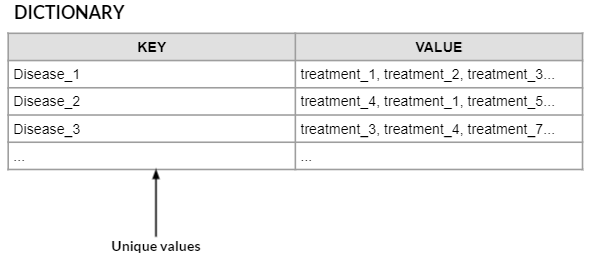

In [22]:
# Declare a dictionary Disease_Treatment to store Disease and Treatment as key value pair
Disease_Treatment = dict()
for i in range(len(Y_pred)):
    # creating a list to store the predictd labels for each word in a sentence
    labels_pred = Y_pred[i]
    Diseases = ""
    Treatments = ""
    for j in range(len(labels_pred)):
        if labels_pred[j] == 'D': 
            # assigning the word whose corresponding label is D to Diseasee variable
            Diseases += test_sent_processed[i].split()[j] + " "
        elif labels_pred[j] == 'T': 
            # assigning the word whose corresponding label is T to Treatments variable
            Treatments += test_sent_processed[i].split()[j] + " "
            
    Diseases = Diseases.strip()
    Treatments = Treatments.strip()
    #print(i)
    #print(Diseases)
    #print(Treatments)

    if Diseases != "" and Treatments != "":
        if Diseases in Disease_Treatment.keys():
            treatment_temp = list(Disease_Treatment[Diseases])
            treatment_temp.append(Treatments)
            Disease_Treatment[Diseases] = treatment_temp
        elif Diseases not in Disease_Treatment.keys():
            Disease_Treatment[Diseases] = Treatments

list(Disease_Treatment.items())[:10]


[('nonimmune hydrops fetalis', 'Trisomy'),
 ('hereditary retinoblastoma', 'radiotherapy'),
 ('unstable angina or non-Q-wave myocardial infarction', 'roxithromycin'),
 ('coronary-artery disease', 'Antichlamydial antibiotics'),
 ('primary pulmonary hypertension ( PPH )', 'fenfluramines'),
 ('essential hypertension', 'moxonidine'),
 ('cellulitis', 'G-CSF therapy intravenous antibiotic treatment'),
 ('foot infection', 'G-CSF treatment'),
 ("early Parkinson 's disease", 'Ropinirole monotherapy'),
 ('sore throat', 'Antibiotics')]

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [23]:
Disease_Treatment['hereditary retinoblastoma']

'radiotherapy'